In [1]:
import pickle, torch, os, wandb
from tqdm import tqdm
import argparse
from torch.utils.data import DataLoader, ConcatDataset
from util import LossFunction, ViscoelasticDataset
from fig_settings import *
from m_encoder import PCAEncoder
import importlib

In [2]:
from sklearn.decomposition import PCA
import numpy as np

In [3]:
folder = f'overleaf/figs'

In [4]:
data_files = ["data/2024-10-13_PC1D_process10_data.pkl",
			#   "data/2024-10-13_PC1D_process11_data.pkl",
			#   "data/2024-10-13_PC1D_process12_data.pkl"
                ]

datasets = [
    ViscoelasticDataset(
        data_path=file,
        step=50,
        device='cpu',
        encoder=True,
    )
    for file in data_files
]

loss_function = LossFunction()
dataset = ConcatDataset(datasets)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)


In [5]:
pca_E = PCA(n_components=60)
pca_nu = PCA(n_components=60)

In [6]:
E_samples = []
nu_samples = []
for idx, (E, nu) in enumerate(dataloader):
    E_samples.append(E.numpy())
    nu_samples.append(nu.numpy())
E_samples = np.concatenate(E_samples, axis=0)
nu_samples = np.concatenate(nu_samples, axis=0)

In [7]:
train_size = int(0.8 * E_samples.shape[0])
test_size = E_samples.shape[0] - train_size
train_E_samples = E_samples[:train_size]
train_nu_samples = nu_samples[:train_size]

test_E_samples = E_samples[train_size:]
test_nu_samples = nu_samples[train_size:]

pca_E.fit(train_E_samples)
pca_nu.fit(train_nu_samples)

PCA(n_components=60)

In [8]:
E_recon = np.cumsum(np.einsum('ji,bj->bji', pca_E.components_, pca_E.transform(test_E_samples)), axis=1) + pca_E.mean_
nu_recon = np.cumsum(np.einsum('ji,bj->bji', pca_nu.components_, pca_nu.transform(test_nu_samples)), axis=1) + pca_nu.mean_

In [9]:
rel_error_E = np.asarray([loss_function.L2RelativeError(torch.tensor(E_recon[:,i]).unsqueeze(-1), torch.tensor(test_E_samples).unsqueeze(-1)).numpy() for i in range (pca_E.n_components_)])
rel_error_nu = np.asarray([loss_function.L2RelativeError(torch.tensor(nu_recon[:,i]).unsqueeze(-1), torch.tensor(test_nu_samples).unsqueeze(-1)).numpy() for i in range (pca_nu.n_components_)])

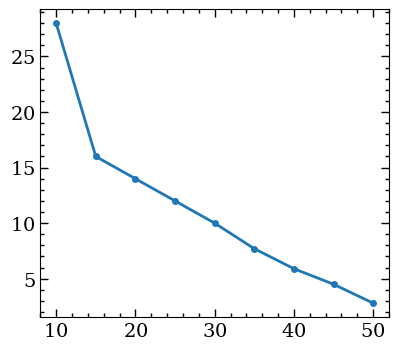

In [45]:
ae_dims = [10, 15, 20, 25, 30, 35, 40, 45, 50]
E_test_rel_errors = [28, 16, 14, 12, 10, 7.7, 5.9, 4.5, 2.8]
plt.plot(ae_dims, E_test_rel_errors, 'o-', label='Autoencoder')

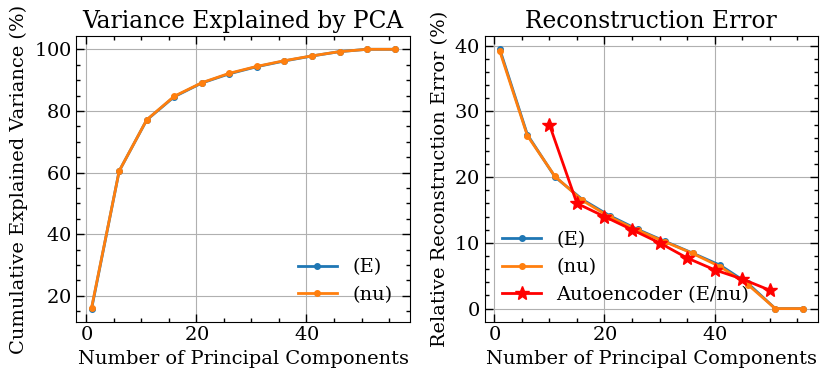

In [55]:
plt.figure(figsize=(8.5,4))
domain = np.arange(1, 61)
step = 5
plt.subplot(1,2,1)
plt.plot(domain[::step], np.cumsum(pca_E.explained_variance_ratio_)[::step]*100, marker='o', label='(E)')
plt.plot(domain[::step], np.cumsum(pca_nu.explained_variance_ratio_)[::step]*100, marker='o', label='(nu)')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Variance Explained by PCA')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(domain[::step], rel_error_E[::step]*100, 'o-', label='(E)')
plt.plot(domain[::step], rel_error_nu[::step]*100, 'o-', label='(nu)')
plt.plot(ae_dims, E_test_rel_errors, '*-', label='Autoencoder (E/nu)', markersize=10, color='red', zorder=3)
plt.legend(loc='lower left')
plt.xlabel('Number of Principal Components')
plt.ylabel('Relative Reconstruction Error (%)')
plt.title('Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{folder}/pca_analysis.pdf')

In [24]:
pca_encoder = PCAEncoder(501, pca_E.n_components_)

In [25]:
pca_encoder.initialize_weights(torch.tensor(pca_E.components_), torch.tensor(pca_E.mean_))

In [26]:
E_encoded1 = pca_encoder(torch.tensor(E_samples).float())
E_encoded2 = pca_E.transform(E_samples)

done


In [27]:
E_recon1 = pca_encoder.decoder(E_encoded1).detach().numpy()
E_recon2 = pca_E.inverse_transform(E_encoded2)

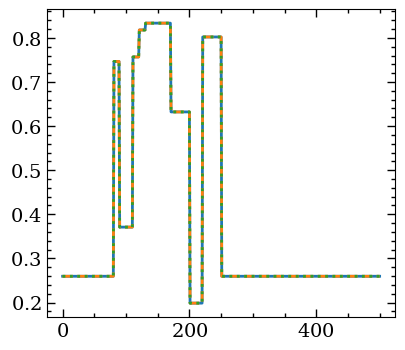

In [ ]:
plt.plot(E_recon1[0])
plt.plot(E_recon2[0], '--')
plt.plot(E_samples[0], ':')

In [20]:
pca_encoder.freeze_encoder()

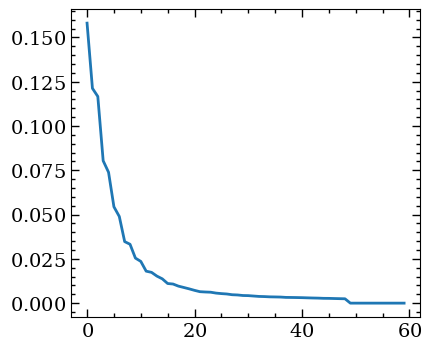

In [23]:
plt.plot(pca_E.explained_variance_ratio_)

In [57]:
pca_E = torch.load('pca_encoder_1/ae_E.pth')

/var/folders/sw/6bcl4ngj0x77mrv5p1s62_k00000gn/T/ipykernel_50593/2865177841.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pca_E = torch.load('pca_encoder_1/ae_E.pth')


In [60]:
pca_E.components.shape

torch.Size([60, 501])